In [1]:
import pickle
import matplotlib.pyplot as plt

# Load final_results results 
with open('final_results.pkl', 'rb') as f:
    final_results = pickle.load(f)

In [2]:
stock_dax40 = 'data/dax40'
stock_dji = 'data/dji'
stock_ftse100 = 'data/ftse100'

window_10 = 10
window_20 = 20
window_50 = 50

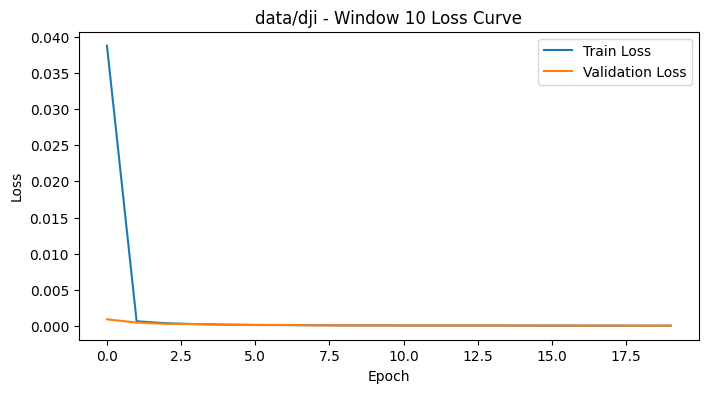

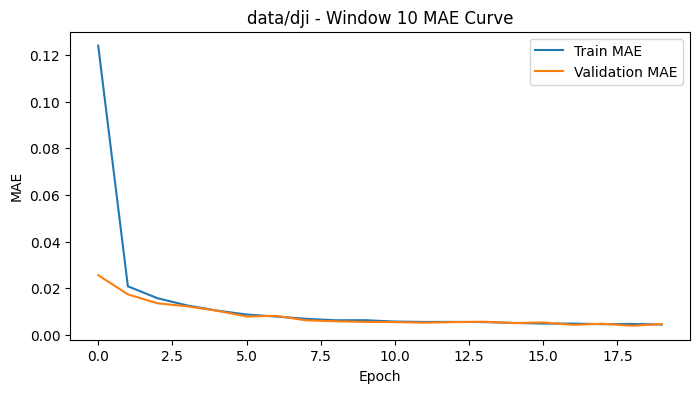

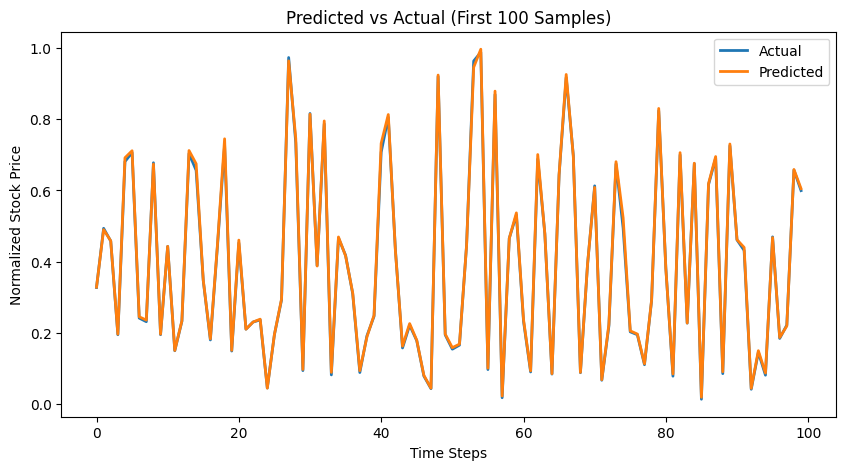

In [9]:
data = final_results[stock_dji][window_10]
history = data['history']
predictions = data['predictions']
actuals = data['actuals']

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{stock_dji} - Window {window_10} Loss Curve')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(8, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'{stock_dji} - Window {window_10} MAE Curve')
plt.legend()
plt.show()

subset_size = 100
plt.figure(figsize=(10, 5))
plt.plot(actuals[:subset_size], label='Actual', linewidth=2)
plt.plot(predictions[:subset_size], label='Predicted', linewidth=2)
plt.title('Predicted vs Actual (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

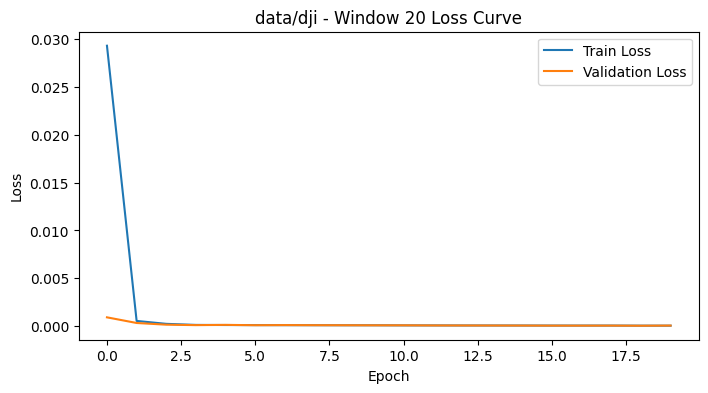

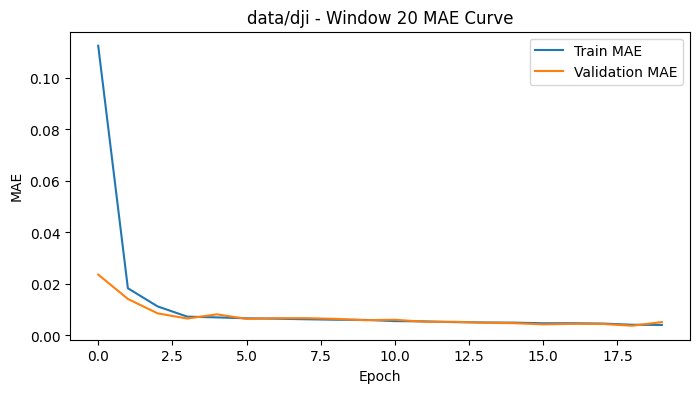

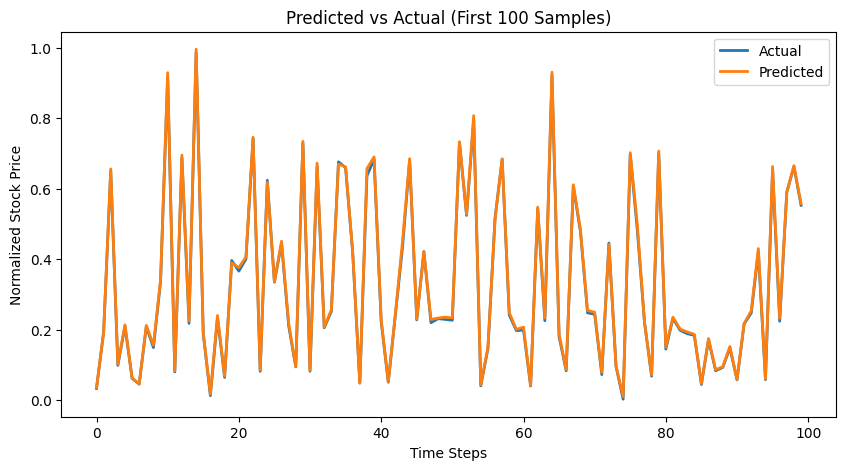

In [10]:
data = final_results[stock_dji][window_20]
history = data['history']
predictions = data['predictions']
actuals = data['actuals']

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{stock_dji} - Window {window_20} Loss Curve')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(8, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'{stock_dji} - Window {window_20} MAE Curve')
plt.legend()
plt.show()

subset_size = 100
plt.figure(figsize=(10, 5))
plt.plot(actuals[:subset_size], label='Actual', linewidth=2)
plt.plot(predictions[:subset_size], label='Predicted', linewidth=2)
plt.title('Predicted vs Actual (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

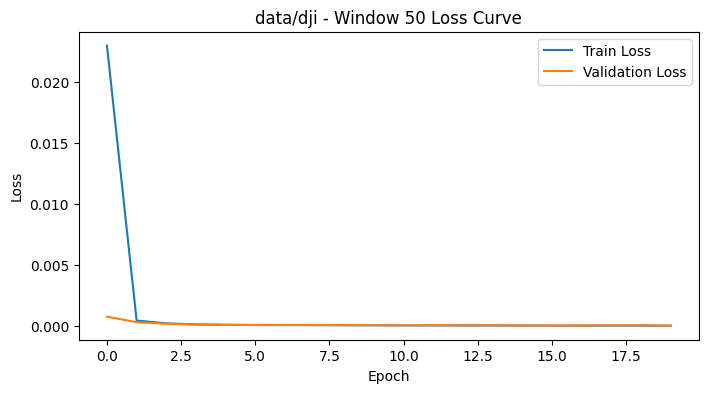

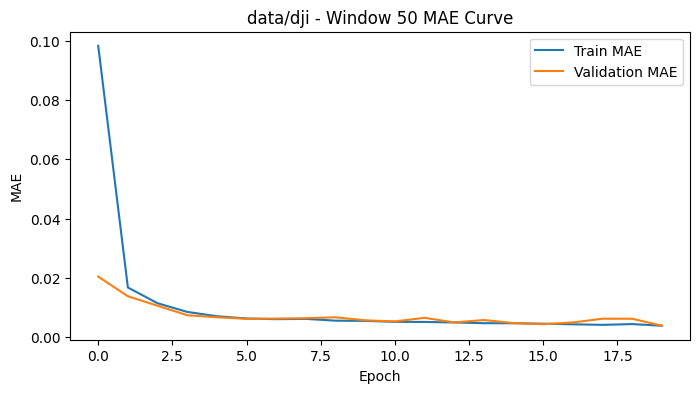

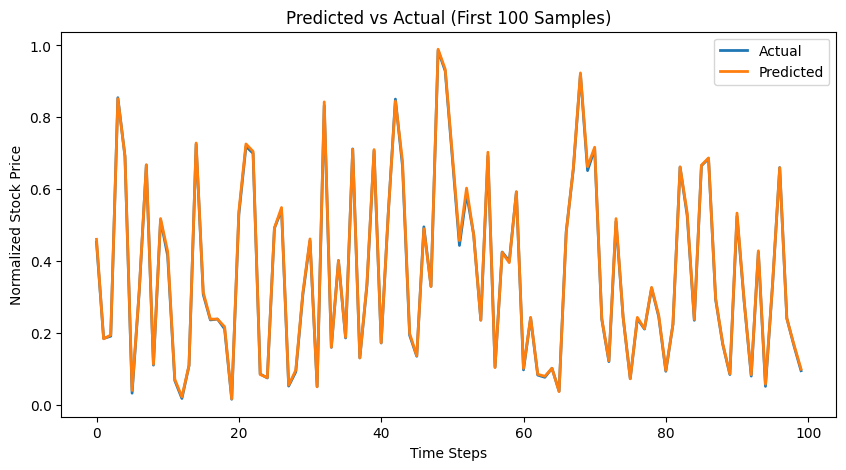

In [11]:
data = final_results[stock_dji][window_50]
history = data['history']
predictions = data['predictions']
actuals = data['actuals']

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{stock_dji} - Window {window_50} Loss Curve')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(8, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'{stock_dji} - Window {window_50} MAE Curve')
plt.legend()
plt.show()

subset_size = 100
plt.figure(figsize=(10, 5))
plt.plot(actuals[:subset_size], label='Actual', linewidth=2)
plt.plot(predictions[:subset_size], label='Predicted', linewidth=2)
plt.title('Predicted vs Actual (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

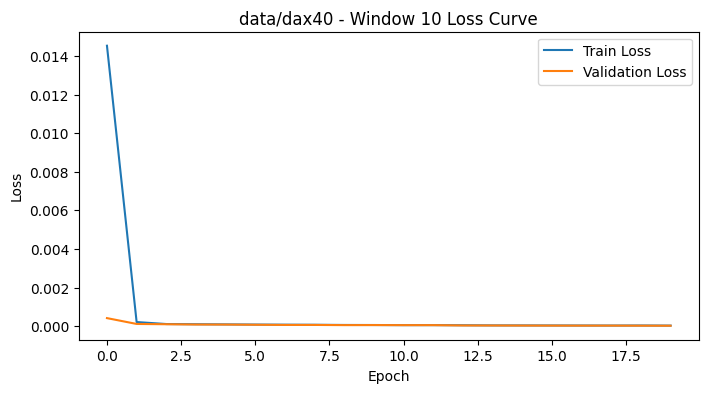

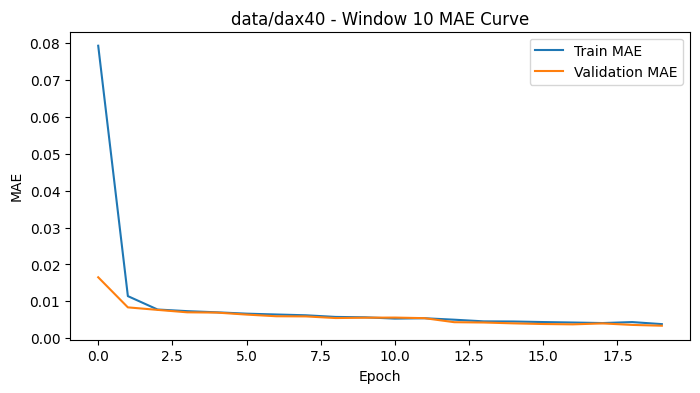

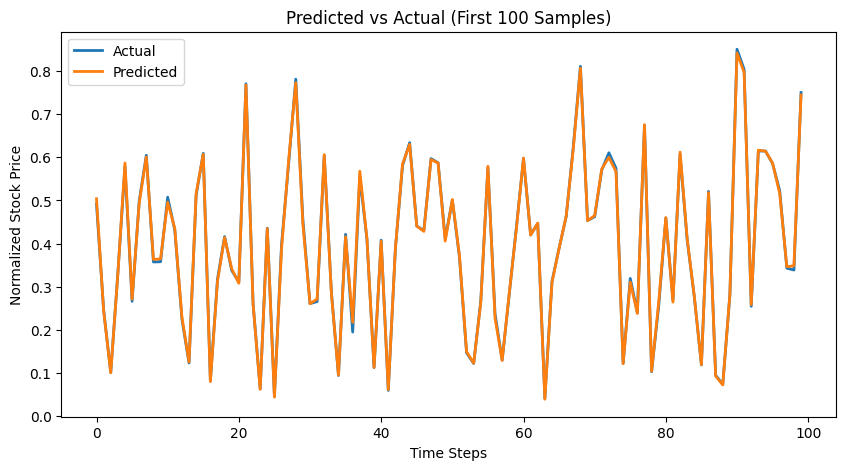

In [12]:
data = final_results[stock_dax40][window_10]
history = data['history']
predictions = data['predictions']
actuals = data['actuals']

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{stock_dax40} - Window {window_10} Loss Curve')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(8, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'{stock_dax40} - Window {window_10} MAE Curve')
plt.legend()
plt.show()

subset_size = 100
plt.figure(figsize=(10, 5))
plt.plot(actuals[:subset_size], label='Actual', linewidth=2)
plt.plot(predictions[:subset_size], label='Predicted', linewidth=2)
plt.title('Predicted vs Actual (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

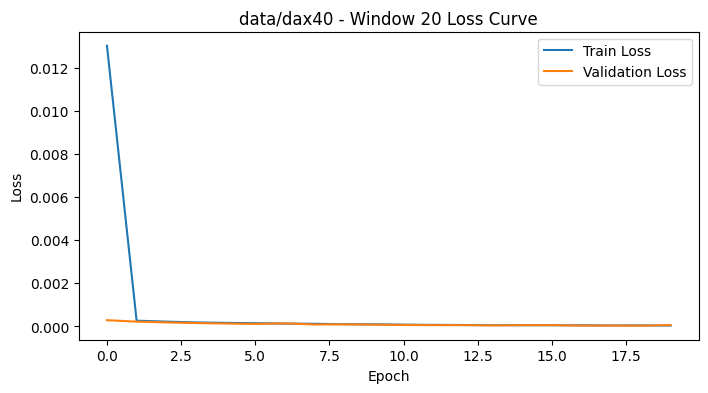

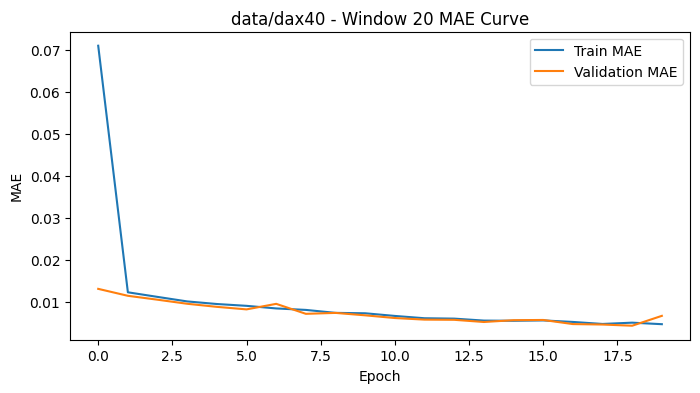

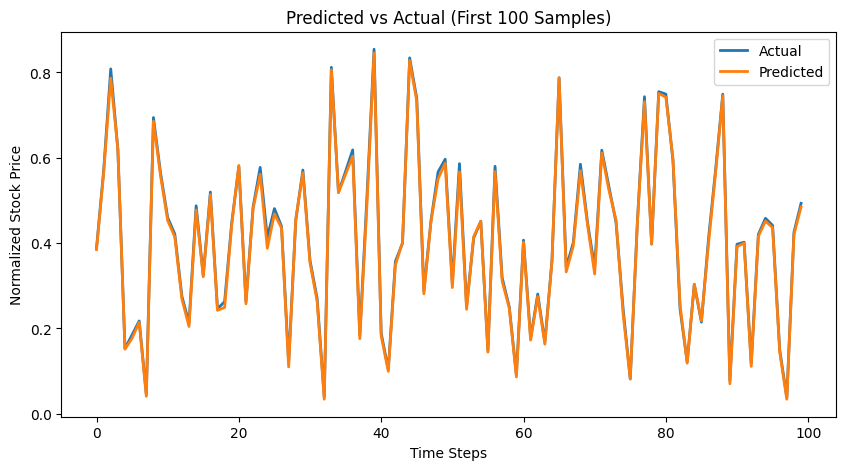

In [13]:
data = final_results[stock_dax40][window_20]
history = data['history']
predictions = data['predictions']
actuals = data['actuals']

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{stock_dax40} - Window {window_20} Loss Curve')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(8, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'{stock_dax40} - Window {window_20} MAE Curve')
plt.legend()
plt.show()

subset_size = 100
plt.figure(figsize=(10, 5))
plt.plot(actuals[:subset_size], label='Actual', linewidth=2)
plt.plot(predictions[:subset_size], label='Predicted', linewidth=2)
plt.title('Predicted vs Actual (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

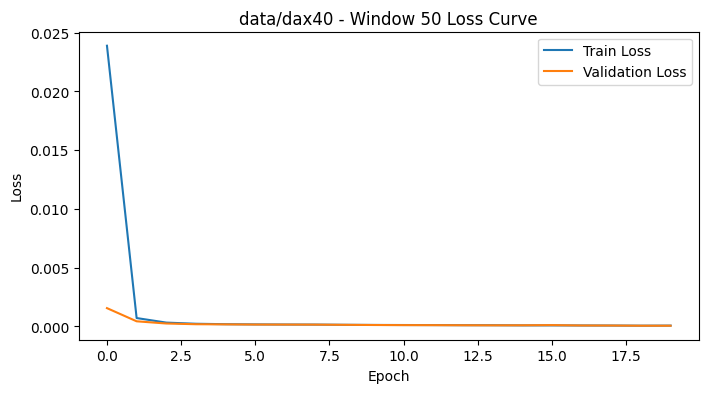

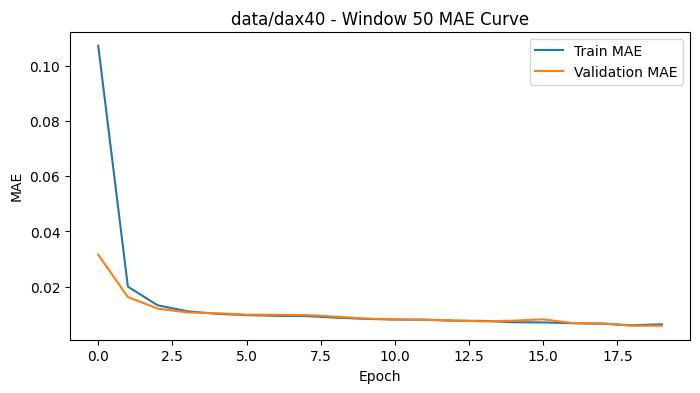

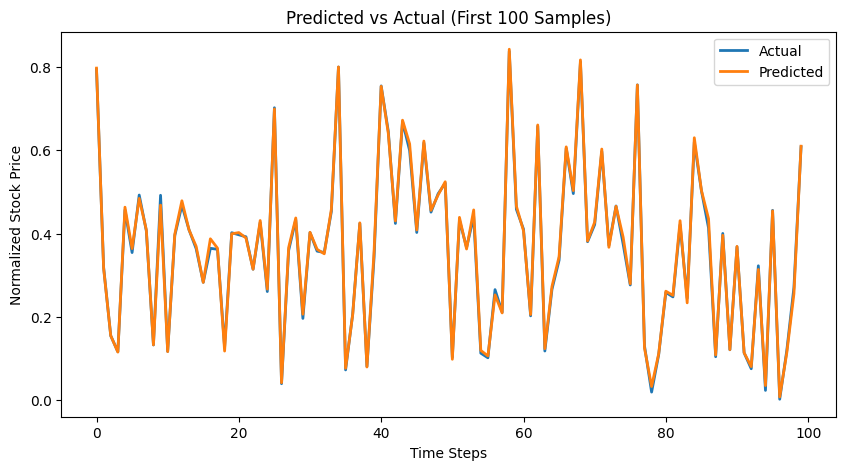

In [14]:
data = final_results[stock_dax40][window_50]
history = data['history']
predictions = data['predictions']
actuals = data['actuals']

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{stock_dax40} - Window {window_50} Loss Curve')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(8, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'{stock_dax40} - Window {window_50} MAE Curve')
plt.legend()
plt.show()

subset_size = 100
plt.figure(figsize=(10, 5))
plt.plot(actuals[:subset_size], label='Actual', linewidth=2)
plt.plot(predictions[:subset_size], label='Predicted', linewidth=2)
plt.title('Predicted vs Actual (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

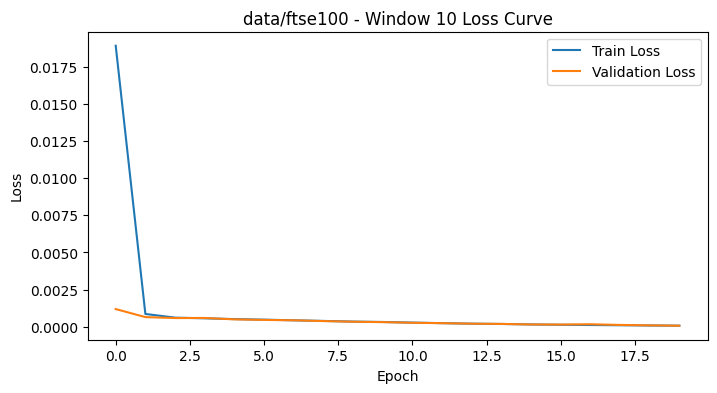

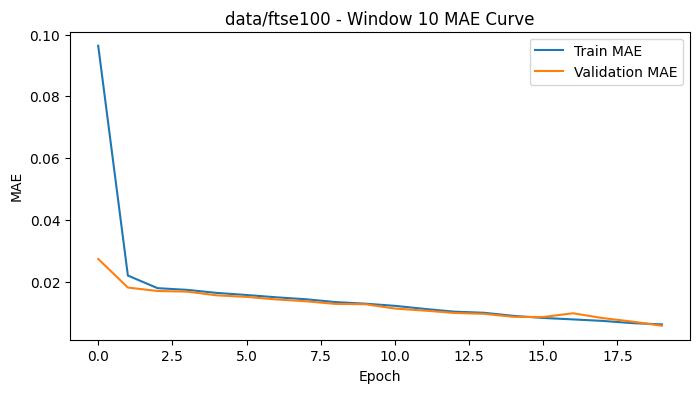

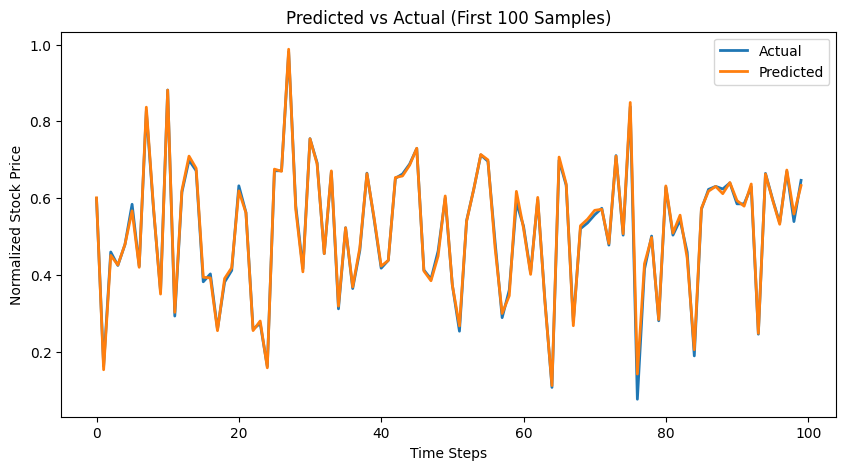

In [15]:
data = final_results[stock_ftse100][window_10]
history = data['history']
predictions = data['predictions']
actuals = data['actuals']

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{stock_ftse100} - Window {window_10} Loss Curve')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(8, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'{stock_ftse100} - Window {window_10} MAE Curve')
plt.legend()
plt.show()

subset_size = 100
plt.figure(figsize=(10, 5))
plt.plot(actuals[:subset_size], label='Actual', linewidth=2)
plt.plot(predictions[:subset_size], label='Predicted', linewidth=2)
plt.title('Predicted vs Actual (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

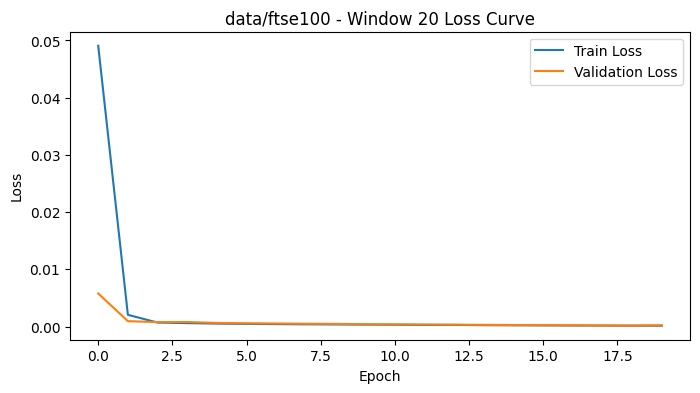

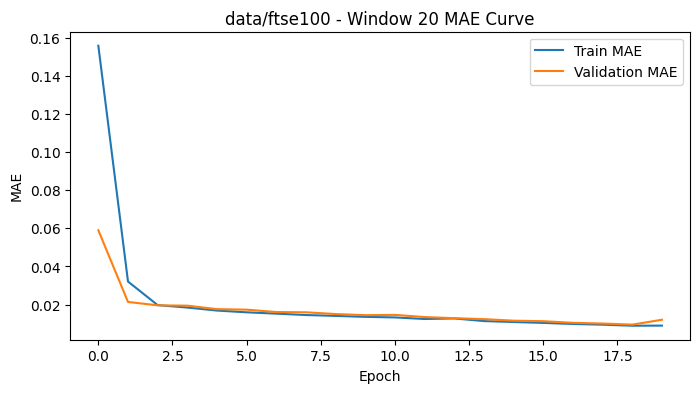

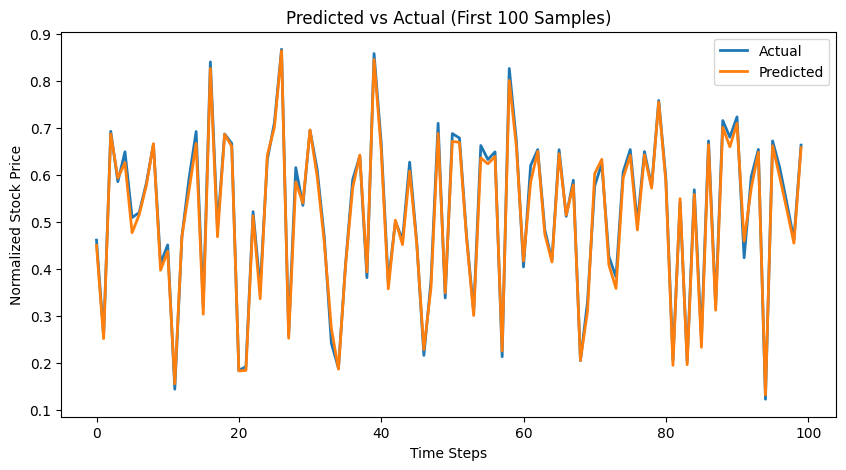

In [16]:
data = final_results[stock_ftse100][window_20]
history = data['history']
predictions = data['predictions']
actuals = data['actuals']

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{stock_ftse100} - Window {window_20} Loss Curve')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(8, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'{stock_ftse100} - Window {window_20} MAE Curve')
plt.legend()
plt.show()

subset_size = 100
plt.figure(figsize=(10, 5))
plt.plot(actuals[:subset_size], label='Actual', linewidth=2)
plt.plot(predictions[:subset_size], label='Predicted', linewidth=2)
plt.title('Predicted vs Actual (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

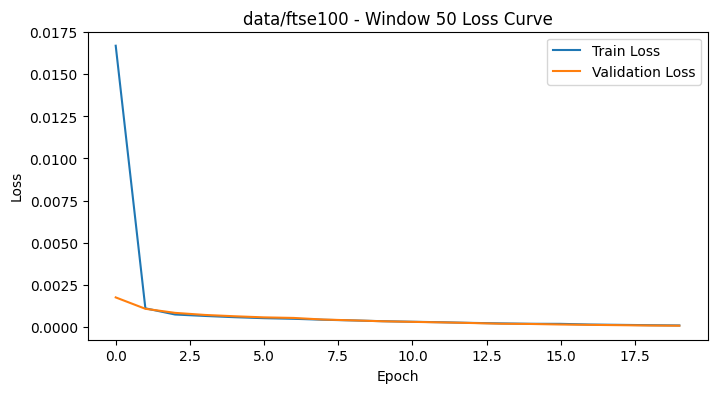

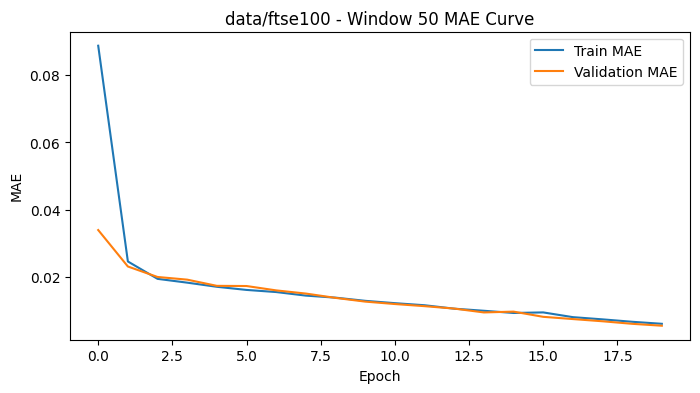

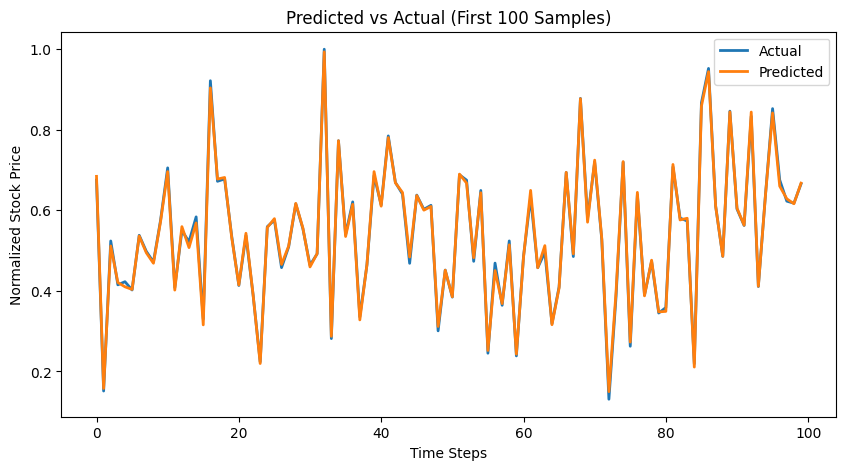

In [17]:
data = final_results[stock_ftse100][window_50]
history = data['history']
predictions = data['predictions']
actuals = data['actuals']

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{stock_ftse100} - Window {window_50} Loss Curve')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(8, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'{stock_ftse100} - Window {window_50} MAE Curve')
plt.legend()
plt.show()

subset_size = 100
plt.figure(figsize=(10, 5))
plt.plot(actuals[:subset_size], label='Actual', linewidth=2)
plt.plot(predictions[:subset_size], label='Predicted', linewidth=2)
plt.title('Predicted vs Actual (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()